In [462]:
from Bio import pairwise2
from Bio.Seq import Seq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns 
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scipy.cluster.hierarchy as shc

In [463]:
species = "horse"
bed_file = 'horse/'+'sep1_244_sorted.bed' # contains loci for all sep1 coordinates
results_file = 'horse/'+'v2output_sep1.txt'# contains VCF info for every sample that has SV in one of the identified coordinates

In [464]:
cons_seq = Seq("nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnTTTTTTTTTTTTTTTTTTAAAGATTTTATT \
    TTTTCCTTTTTCTCCCCAAAGCCCCnnnnCCGGTACnnnnnnnATAGTTGTGTATTCTTC \
    GTTGTnnnnGGGTTCTTCTAGTnTGTGGCATGTGGGACGCTnGCCTCAGCGTGGTCTGAT \
    GAGCAGTGCCATGTCCGCGCCCAGGATTnCGnnnAACCAACGAAACACTGGGCCGCCTGC \
    AGCGGAGCGCnnnnGnnCGAACTTAACCACTCGGCCACGGGGGCCAGCCCCnnnnnnnnn \
    nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn")
# Finding similarities
#score = pairwise2.align.globalxx(seq1, seq1, score_only = True)
#print(score)
print(len(cons_seq))
colors = {'PRZEWALSKI' : 'red', 'AKHAL-TEKE' : 'blue', 'ARABIAN' : 'green', \
          'QUARTER HORSE' : 'yellow', "MONGOLIAN" : "brown", "THOROUGHBRED" : 'orange', \
          'FRIESIAN' : 'black', 'HANOVARIAN' : 'pink', 'JEJU HORSE' : 'gray', \
          'CURLY HORSE' : 'purple', 'DEBAO' : 'teal', 'CRIOLLO' : 'tan'}

362


In [465]:
# get all loci
entries = []
with open(bed_file) as f:
    lines = f.readlines()
    for line in lines: #
        line = line.split()
        end = int(line[1]) + int(line[2])
        t = ">"+line[0]+":"+line[1]+"-"+str(line[1])
        if line[0] not in ['X','Y']:
            entries.append(t)
meta_data = pd.read_csv('horse/horse_sra_simple.csv')
meta_data.columns = ['sra','breed']
color_col = []
for index, row in meta_data.iterrows():
    row['breed'] = row['breed'] + str(random.randint(0,9))

In [466]:
samples = {}
with open(results_file) as f:
    lines = f.readlines()
    for line in lines:
        if "output" in line:
            sample_name = line.split('/')[1].strip()
            breed_name = meta_data.loc[meta_data['sra'] == sample_name]
            #print(breed_name, sample_name)
            breed_name = breed_name['breed'].values[0]
            samples[breed_name] = np.zeros(len(entries)) 
            
        else:
            t = line.split()
            chrom = t[0]
            start = t[1]
            end = start
            seq = re.search('SVINSSEQ=(.*);SPLIT_READS',line)
            seq = seq.group(1)
            s = ">"+chrom+":"+start+"-"+end
            if s in entries and chrom not in  ['X', 'Y']: # SV is in TE loci, get percent identify to cons seq
                idx = entries.index(s)
                score = pairwise2.align.globalxx(cons_seq, Seq(seq), score_only = True)
                samples[breed_name][idx] = score
print(len(samples.keys()))

36


In [467]:
df=pd.DataFrame.from_dict(samples,orient='index').transpose()

In [468]:
#df = df.loc[:, ~df.columns.str.startswith('QUARTER')]
#df = df.loc[:, ~df.columns.str.startswith('FRIESIAN')]
#df = df.loc[:, ~df.columns.str.startswith('MONGOLIAN')]
#df = df.loc[:, ~df.columns.str.startswith('PRZ')]
#df = df.loc[:, ~df.columns.str.startswith('THOROUGH')]
#df = df.loc[:, ~df.columns.str.startswith('CRIOLLO')]
#df = df.loc[:, ~df.columns.str.startswith('DEBAO')]
#df = df.loc[:, ~df.columns.str.startswith('HANOV')]
#df = df.loc[:, ~df.columns.str.startswith('JEJU')]
#df = df.loc[:, ~df.columns.str.startswith('CURLY')]
#df = df.loc[:, ~df.columns.str.startswith('AKHAL')]
#df = df.loc[:, ~df.columns.str.startswith('ARAB')]

cols = list(df.columns.values)
cols = sorted(cols, key=str.lower)
df_new = df[cols]
df_final = df_new.iloc[0:900]
df_final = df_final.transpose()

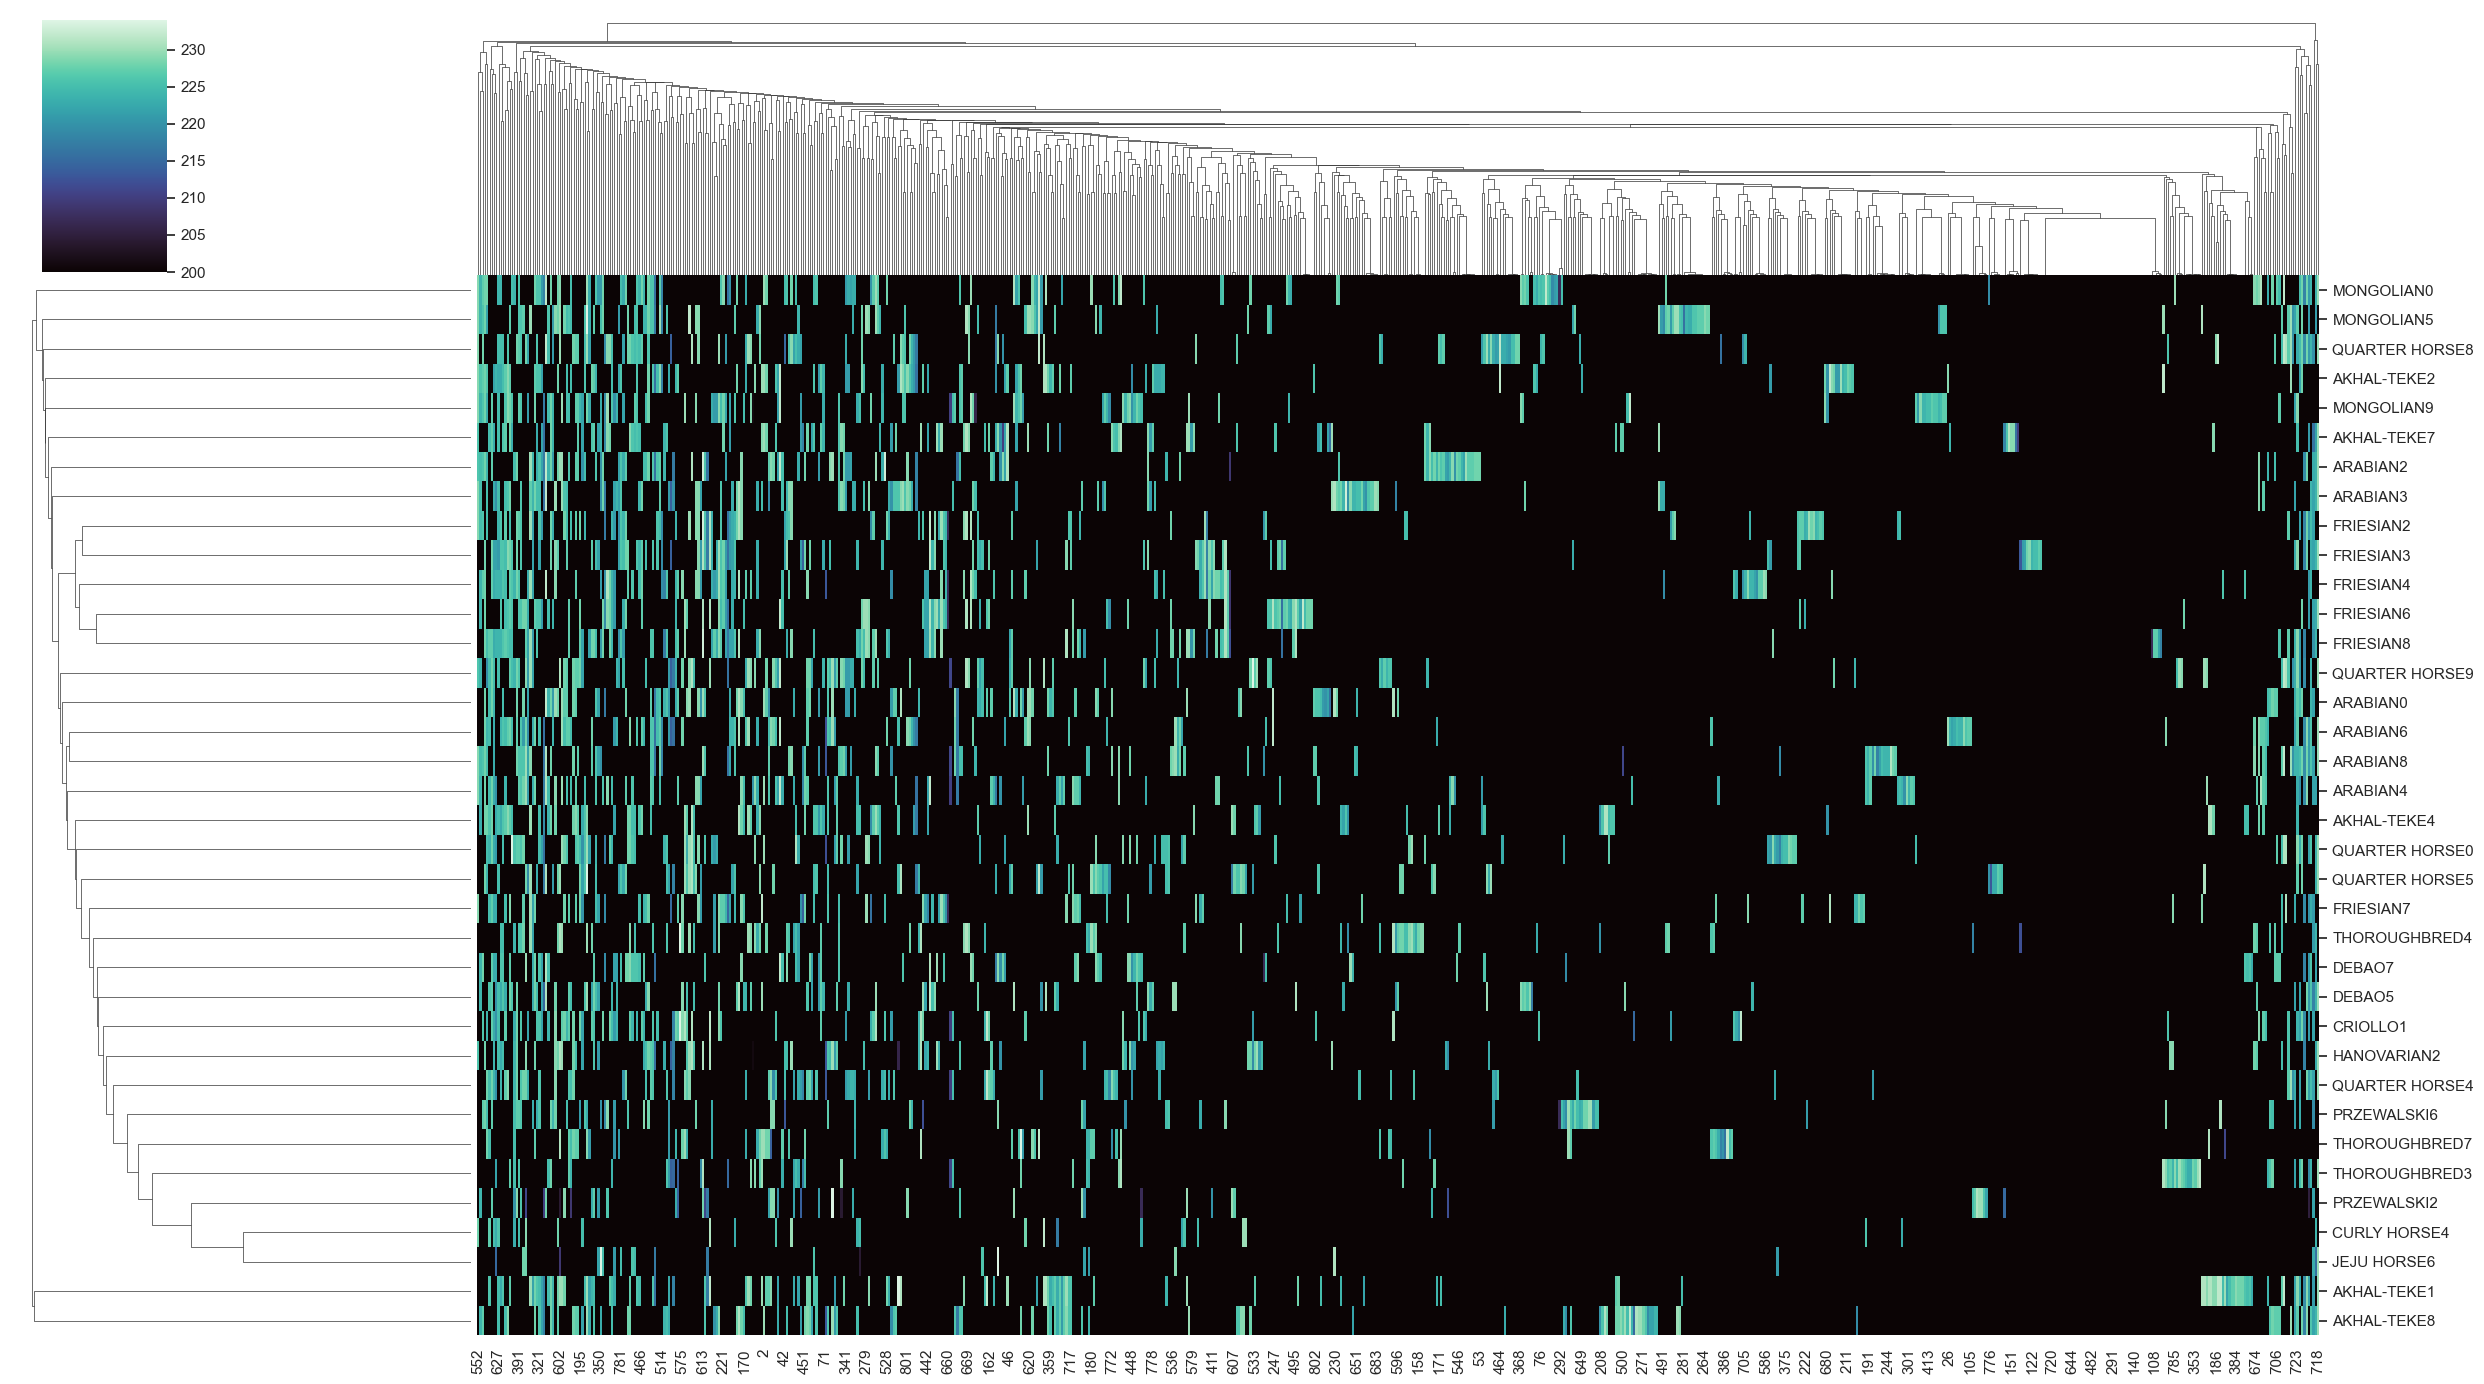

In [473]:
#plt.subplots(figsize=(25,15))
#sns.heatmap(df_final, cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
ls = sns.clustermap(df_final, cmap = sns.color_palette("mako", as_cmap=True), vmin=200, figsize=(25,14))
fig = ls.fig
fig.savefig("pid.png") 

In [470]:

X = df_final.loc[:].values
x_scaled = StandardScaler().fit_transform(X)
y = list(df_final.index)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(x_scaled)
## Create dataframe
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])
pca_df['target'] = y
t = list(pca_df['target'].values)
cs = [colors[i[:-1]] for i in t] 
pca_df['colors'] = cs
c_dict = dict(zip(pca_df.target, pca_df.colors))
#print(pca_df)

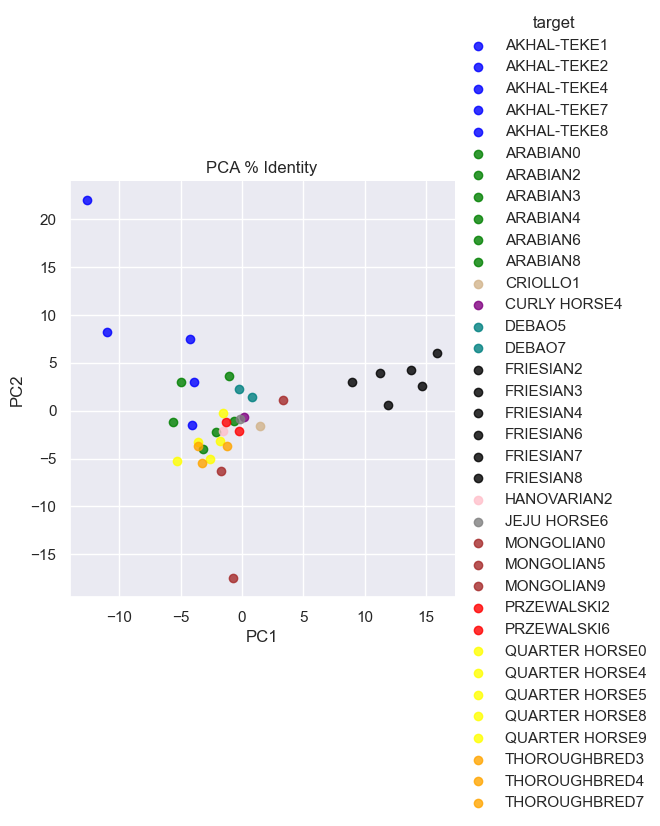

In [471]:
import seaborn as sns
sns.set()
 
ls = sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    palette=c_dict,
    hue='target',
    fit_reg=False, 
    legend=True
    )
#ls = (ls.set_axis_labels("PC1","PC2").set(xlim=(-10,20),ylim=(-10,25)))
plt.title('PCA ERE1 Type')
plt.title('PCA % Identity')
plt.show()

In [ ]:
df=pd.DataFrame.from_dict(samples,orient='index').transpose()
cols = list(df.columns.values)
cols = sorted(cols, key=str.lower)
df_new = df[cols]
df_final = df_new.iloc[0:900]
df_final = df_final.transpose()

X = df_final.loc[:].values

X_cols_max = X.max(axis=0)
#X_cols_min = X.min(axis=0)
X_cols_min = np.where(X>0, X, np.inf).min(axis=0)
#X_cols_max = np.where(X>0, X, np.inf).max(axis=0)
X = df_final.loc[:].values
X_count = np.count_nonzero(X, axis=0)
labels = list(df_final.index)
X_count = X_count/len(labels) * 100
X_range = X_cols_max - X_cols_min


#print(X_range.shape)

plt.figure(figsize=(14,5))
#sc = plt.scatter(y,  , c=new_count, s=new_count,alpha=0.5)

#for i in range(len(X_cols_min)):
    #print(y[i], X_cols_min[i], X_cols_max[i])
#    plt.vlines(y[i], ymin = X_cols_min[i], ymax = X_cols_max[i])
#plt.ylim(200,240)

sns.displot(X_range, bins= 100, figsize=(25,14))